# Subbundles Part 6: Visualization

**Subbundle** - a subgroup of streamlines with a set of common properties

In [1]:
from utils import *

import os.path as op

import tempfile
import numpy as np
import pandas as pd

import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.io.stateful_tractogram import StatefulTractogram
from dipy.stats.analysis import afq_profile, gaussian_weights

from sklearn.metrics.cluster import adjusted_rand_score

import seaborn as sns
import matplotlib.pyplot as plt
from dipy.viz import window, actor
from IPython.display import Image

from AFQ import api
import AFQ.data as afd

from AFQ.viz.fury_backend import visualize_volume
from AFQ.viz.fury_backend import visualize_bundles

/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Streamlines (from Part 2)

<span style="color:blue">**TODO: add test retest comparision**</span>. This will be in notebook 7

In [2]:
big_plots = False

In [3]:
dataset_name = 'HCP'
# dataset_name = 'HCP_retest'

In [4]:
# subjects = get_subjects(dataset_name)
subjects = get_subjects_small(dataset_name)
# subjects = get_subjects_medium(dataset_name)
# subjects = ['103818']
# subjects = ['105923']

In [5]:
myafq = get_afq(dataset_name)
display(myafq.data_frame)

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,sl_counts,results_dir,gtab,dwi_affine,dwi_img
0,100307,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,103818,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,105923,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3,111312,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,114823,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
5,115320,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


In [6]:
# bundle_names = [*myafq.bundle_dict]
bundle_names = ['SLF_L', 'SLF_R']
# bundle_names = ['ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP'] 
# bundle_names = ['SLF_L', 'SLF_R', 'ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP']
# bundle_names = ['SLF_L']
# bundle_names = ['SLF_R']

In [7]:
target_dirs = {}

for subject in subjects:
    target_dirs[subject] = {}
    
    loc = get_iloc(myafq, subject)

    for bundle_name in bundle_names:
        target_dir = get_dir_name(myafq, dataset_name, bundle_name, loc)
        target_dirs[subject][bundle_name] = target_dir

In [8]:
tg_fnames = {}
tractograms = {}
streamlines = {}
affines = {}

for subject in subjects:
    tg_fnames[subject] = {}
    tractograms[subject] = {}
    streamlines[subject] = {}
    affines[subject] = {}
    
    loc = get_iloc(myafq, subject)

    for bundle_name in bundle_names:
        tg_fnames[subject][bundle_name] = get_tractogram_filename(myafq, bundle_name, loc)
        tractograms[subject][bundle_name] = load_tractogram(tg_fnames[subject][bundle_name], 'same')
        streamlines[subject][bundle_name] = tractograms[subject][bundle_name].streamlines
        affines[subject][bundle_name] = tractograms[subject][bundle_name].affine

## Clusters (from Part 5)

In [9]:
model_names = ['mase']

idxs = {}
labels = {}

for subject in subjects:
    idxs[subject] = {}
    labels[subject] = {}
    for bundle_name in bundle_names:
        idxs[subject][bundle_name] = []
        labels[subject][bundle_name] = []
        
        target_dir = target_dirs[subject][bundle_name]
        
        label = f'mase_pairwise_warped_fa_r2_is_mdf'
        labels[subject][bundle_name].append(label)
        idx = np.load(op.join(target_dir, f'{label}_idx.npy'))
        idxs[subject][bundle_name].append(idx)

#### Label Switching

Change order of clusters from largest to smallest

In [10]:
for subject in subjects:
    for bundle_name in bundle_names:
        resorted_idxs = []

        for idx in idxs[subject][bundle_name]:
            resorted_idxs.append(resort_cluster_ids(idx))
    
            idxs[subject][bundle_name] = resorted_idxs

#### Subselect models

In [11]:
pd.DataFrame(labels)

,103818,105923
SLF_L,[mase_pairwise_warped_fa_r2_is_mdf],[mase_pairwise_warped_fa_r2_is_mdf]
SLF_R,[mase_pairwise_warped_fa_r2_is_mdf],[mase_pairwise_warped_fa_r2_is_mdf]


In [12]:
bundle_labels = {}
for subject in subjects:
    bundle_labels[subject] = {}
    for bundle_name in bundle_names:
        bundle_labels[subject][bundle_name] = []
        for idx, label in zip(idxs[subject][bundle_name], labels[subject][bundle_name]):
            for cluster_id in np.unique(idx):
                bundle_labels[subject][bundle_name].append(label + ' ' + str(cluster_id))

In [13]:
pd.DataFrame(bundle_labels)

,103818,105923
SLF_L,"[mase_pairwise_warped_fa_r2_is_mdf 0, mase_pai...","[mase_pairwise_warped_fa_r2_is_mdf 0, mase_pai..."
SLF_R,"[mase_pairwise_warped_fa_r2_is_mdf 0, mase_pai...","[mase_pairwise_warped_fa_r2_is_mdf 0, mase_pai..."


#### Group Clustered Streamline Indicies

In [14]:
cluster_ids = {}
clusters = {}
clusters_cnts = {}

for subject in subjects:
    cluster_ids[subject] = {}
    clusters[subject] = {}
    clusters_cnts[subject] = {}
    
    for bundle_name in bundle_names:
        cluster_ids[subject][bundle_name] = []
        clusters[subject][bundle_name] = []
        clusters_cnts[subject][bundle_name] = {}
        
        for idx, label in zip(idxs[subject][bundle_name], labels[subject][bundle_name]):
            cluster_id = np.unique(idx)
            cluster_ids[subject][bundle_name].append(cluster_id)
            
            # per cluster streamline indicies
            cluster = np.array([np.where(idx == i)[0] for i in cluster_id])
            clusters[subject][bundle_name].append(cluster)
            
#             print(f"{subject} {bundle_name} {label} streamlines per cluster:", np.bincount(idx))
            clusters_cnts[subject][bundle_name][label] = np.bincount(idx)

In [15]:
display(pd.DataFrame(cluster_ids))

,103818,105923
SLF_L,"[[0, 1, 2]]","[[0, 1]]"
SLF_R,"[[0, 1]]","[[0, 1]]"


In [16]:
cnts_df = pd.DataFrame(clusters_cnts)
display(cnts_df)

,103818,105923
SLF_L,"{'mase_pairwise_warped_fa_r2_is_mdf': [334, 22...","{'mase_pairwise_warped_fa_r2_is_mdf': [283, 267]}"
SLF_R,"{'mase_pairwise_warped_fa_r2_is_mdf': [585, 575]}","{'mase_pairwise_warped_fa_r2_is_mdf': [430, 339]}"


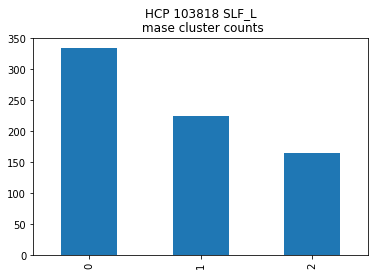

,mase_pairwise_warped_fa_r2_is_mdf
0,334
1,225
2,165


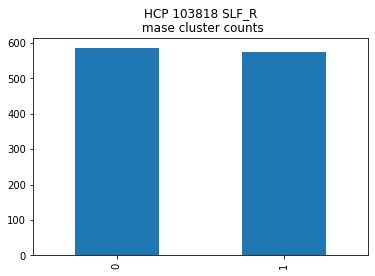

,mase_pairwise_warped_fa_r2_is_mdf
0,585
1,575


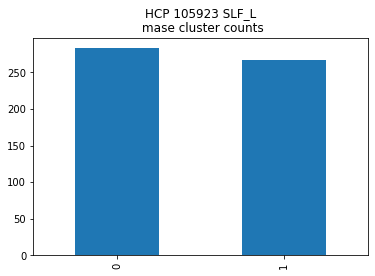

,mase_pairwise_warped_fa_r2_is_mdf
0,283
1,267


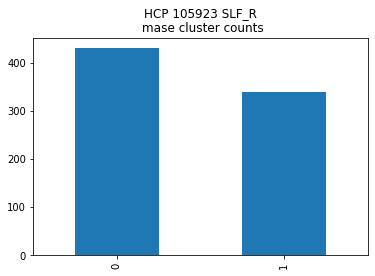

,mase_pairwise_warped_fa_r2_is_mdf
0,430
1,339


In [17]:
for subject in subjects:
    for bundle_name in bundle_names:
        if len(cnts_df.loc[bundle_name][subject].items()) > 0:
            for model_name in model_names:
                my_dict = {k: v for k,v in cnts_df.loc[bundle_name][subject].items() if k.startswith(model_name)}
                my_df = pd.DataFrame.from_dict(my_dict, orient='index')
                my_df.T.plot(kind='bar', legend=None, color='tab:blue', title=f'{dataset_name} {subject} {bundle_name}\n {model_name} cluster counts')
                plt.show()
                display(my_df.T)

<span style="color:blue">**TODO: find streamline changes between models**</span>
- Select subject
- Select bundle
- Select models
- Compare each cluster
- Find differences
- Plot streamines, streamline profiles, subbundle profiles....

#### External Evaluation: ARI

### Dice's Coeeficient

Twice the area of overlap divided by the sum of both areas

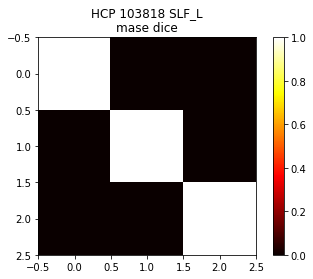

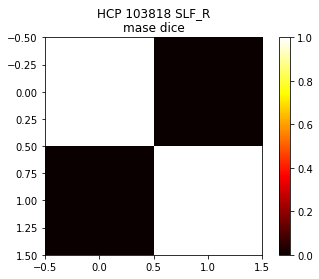

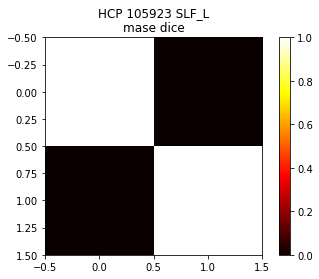

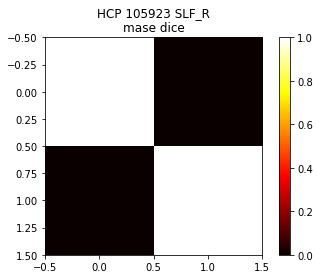

In [19]:
from scipy.spatial.distance import dice

for subject in subjects:
    for bundle_name in bundle_names:
        for model_name in model_names:

            # select a subset of models
            my_models = []
            num_clusters = 0

            for ids, label in zip(cluster_ids[subject][bundle_name], labels[subject][bundle_name]):
                if model_name in label and 'pairwise_warped' in label and 'mdf' in label:
                    my_models.append(label)
                    num_clusters += len(ids)
            
            dice_matrix = np.zeros((num_clusters, num_clusters))

            ii=0
            jj=0

            for ids1, idx1, label1 in zip(cluster_ids[subject][bundle_name], clusters[subject][bundle_name], labels[subject][bundle_name]):
                if label1 not in my_models:
                    continue

                for i in ids1:
                    bundle1 = np.zeros(len(streamlines[subject][bundle_name]))
                    bundle1[idx1[i]] = 1

                    for ids2, idx2, label2 in zip(cluster_ids[subject][bundle_name], clusters[subject][bundle_name], labels[subject][bundle_name]):
                        if label2 not in my_models:
                            continue

                        for j in ids2:
                            bundle2 = np.zeros(len(streamlines[subject][bundle_name]))
                            bundle2[idx2[j]] = 1

                            # scipy's dice function returns the dice *dissimilarity*
                            # dice_matrix[ii][jj] = 1-dice(bundle1, bundle2)
                            
                            # use weighted dice
                            dice_matrix[ii][jj] =  (np.sum(bundle1 * bundle2.astype(bool)) + np.sum(bundle2 * bundle1.astype(bool))) \
                                                    / (np.sum(bundle1) + np.sum(bundle2))
                            jj+=1
                    ii+=1
                    jj=0

            if (big_plots):
                plt.figure(figsize = (len(bundle_labels),len(bundle_labels)))
                plt.title('dice')
                plt.imshow(dice_matrix, cmap='hot', interpolation='nearest')
                for (i, j), z in np.ndenumerate(dice_matrix):
                    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                             bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
                plt.colorbar()
                plt.xticks(np.arange(len(bundle_labels)), bundle_labels, rotation=90)
                plt.yticks(np.arange(len(bundle_labels)), bundle_labels)
                plt.show()
            else:
                plt.figure()
                plt.title(f'{dataset_name} {subject} {bundle_name}\n{model_name} dice')
                plt.imshow(dice_matrix, cmap='hot', interpolation='nearest')
                plt.colorbar()
                plt.show()

### [Bundle Adjacency (BA)](https://www.nature.com/articles/s41598-020-74054-4)

> Use bundle adjacency (BA) to calculate the shape similarity between the same type of bundles **across subjects and groups** ... BA uses a minimum direct flip (MDF) distance to get the distance between two streamlines

> 𝐵𝐴(𝐵1,𝐵2)=0.5(𝑐𝑜𝑣𝑒𝑟𝑎𝑔𝑒(𝐵1,𝐵2)+𝑐𝑜𝑣𝑒𝑟𝑎𝑔𝑒(𝐵2,𝐵1))

> Bundle adjacency is a bounded measure and takes values between 0 to 1, such that 0 means no shape similarity, i.e. no similar adjacent clusters of streamlines were found between the two bundles and 1 means maximum similarity, i.e. all clusters of both bundles had at least one neighbor.

## Visualize clustered streamlines

- Are there any anatomically distinct subbundles?

In [ ]:
interact = False

visualize subbundles

<span style="color:blue">**TODO: `streamtube` plots are not anatomically oriented**</span>

<span style="color:blue">**TODO: coordinate `colormap` to make subbundle identification consistent**</span>

visualize subbundles separately

## ALTERNATIVELY: `fury_backend.visualize_bundles`

In [ ]:
colors = sns.color_palette("bright6")

visualize all bundles

In [ ]:
volumes = {}

for subject in subjects:
    loc = get_iloc(myafq, subject)
    
    volume, color_by_volume = myafq._viz_prepare_vols(
        myafq.data_frame.loc[loc],
        volume=None,
        xform_volume=False,
        color_by_volume=None,
        xform_color_by_volume=False
    )
    
    volumes[subject] = volume

visualize targeted bundle

visualize subbundles separately

visualize subbundles

<span style="color:blue">**TODO: Color bundles bug in fury `visualize_bundles`.**</span>

<span style="color:blue">**TODO: `azimuth` hides the volume.**</span>

Similar comment from old vtk thread http://vtk.1045678.n5.nabble.com/Flipping-the-image-with-vtkCamera-Yaw-makes-image-disappear-td1243738.html

In [ ]:
from dipy.viz import ui

# fa
for subject in subjects:
#     if subject != '103818':
#         continue
    volume = volumes[subject]
    for bundle_name in bundle_names:
        
        target_dir = target_dirs[subject][bundle_name]
        
        for ids, idx, label in zip(cluster_ids[subject][bundle_name], clusters[subject][bundle_name], labels[subject][bundle_name]):
#             if not('sc' in label and 'pairwise' in label and 'mdf' in label):
#                 continue
            
#             print(f'{subject} {bundle_name} {label} axial')

#             title = ui.TextBlock2D(text=f'{subject} {bundle_name} {label}',
#                                    color=(0,0,0))
                        
            scene = window.Scene()
      
            figure = visualize_volume(
                volume,
                interact=False,
                inline=False,
                figure=scene
            )

            figure.SetBackground(1,1,1)

            for i in ids:    
                tg = StatefulTractogram.from_sft(streamlines[subject][bundle_name][idx[i]], tractograms[subject][bundle_name])
                tg.to_vox()

#                 streamline_actor = actor.streamtube(tg.streamlines, colors[i]) #, linewidth=.6)
#                 streamline_actor.GetProperty().SetBackfaceCulling(False)

                # https://github.com/fury-gl/fury/issues/114
#                 streamline_actor = actor.streamtube(tg.streamlines, colors[i], lod=False)

                streamline_actor = actor.streamtube(tg.streamlines, colors[i], linewidth=0.6)

                # TODO debugging streamline width        
        #         streamline_actor.GetProperty().SetRenderLinesAsTubes(True)
        #         streamline_actor.GetProperty().SetLineWidth(6)
        #         print(streamline_actor.GetProperty())

                figure.add(streamline_actor)

                if interact:
                    window.show(figure, size=(600, 400))

        #     image_actor_z = actor.slicer(volume, opacity=0.6)
        #     figure.add(image_actor_z)
        
#             scene.add(title)

#             showm = window.ShowManager(scene)
#             showm.scene.add(title)

            # Why is scene vertically reflected compare window.show(scene) versus window.snapshot(scene)
            # See similar issue http://vtk.1045678.n5.nabble.com/Problem-with-upside-down-image-itk-vtk-td5716361.html
        
#             scene.set_camera(view_up=(1,0,0))
#             display(scene.camera_info())
#             display(window.analyze_scene(scene).actors)
            
                    
            fname = tempfile.NamedTemporaryFile().name + '.png'
            window.snapshot(scene, fname=fname, size=(600, 400))
#             display(Image(fname))
            
            # work around for title see
            # http://vtk.1045678.n5.nabble.com/vtkCaptionActor2D-text-orientation-td1232191.html
            plt.imshow(plt.imread(fname))
            plt.title(f'{dataset_name} {subject} {bundle_name}\n{label}')
            plt.axis('off')
            
            f_name = op.join(target_dir, f'{bundle_name}_{label}_anat_0.png')
            print(f_name)
            plt.savefig(f_name)
            
            plt.show()
            
#             print(f'{subject} {bundle_name} {label} sagittal')
            figure.azimuth(90)
            figure.roll(90)

        #     image_actor_x = image_actor_z.copy()
        #     image_actor_x.display(image_actor_x.shape[0]//2, None, None)

        #     image_actor_x = image_actor_z.copy()
        #     x_midpoint = int(np.round(image_actor_x.shape[0] / 2))
        #     image_actor_x.display_extent(x_midpoint,
        #                                  x_midpoint, 0,
        #                                  image_actor_x.shape[1] - 1,
        #                                  0,
        #                                  image_actor_x.shape[2] - 1)

        #     figure.add(image_actor_x)
            
#             window.show(scene, reset_camera=False)
            fname = tempfile.NamedTemporaryFile().name + '.png'
            window.snapshot(figure, fname=fname, size=(600, 400))
#             display(Image(fname))
            
#             assert False
            plt.imshow(plt.imread(fname))
            plt.title(f'{dataset_name} {subject} {bundle_name}\n{label}')
            plt.axis('off')
            
            f_name = op.join(target_dir, f'{bundle_name}_{label}_anat_1.png')
            print(f_name)
            plt.savefig(f_name)
            
            plt.show()

<span style="color:blue">**TODO: Currently Debugging.**</span>

<span style="color:blue">**TODO: add profile and anatomical for individual clusters**</span>

### Plot tract profiles for clusters

In [ ]:
# print(get_scalar_filename(myafq, 'dti_fa', loc))
# !ls -la /Users/bloomdt/AFQ_data/HCP_1200/derivatives/afq/sub-103818/ses-01/sub-103818_dwi_model-dti_fa.nii.gz

for subject in subjects:

#     if subject != '103818':
#         continue
        
    loc = get_iloc(myafq, subject)
    fa_scalar_data = nib.load(get_scalar_filename(myafq, 'dti_fa', loc)).get_fdata()
#     print(np.count_nonzero(np.array(fa_scalar_data)))

    for bundle_name in bundle_names:
        
        target_dir = target_dirs[subject][bundle_name]

        plt.figure()
        plt.title(f"{dataset_name} {subject} {bundle_name}\n fa tract profiles")
        plt.plot(
            afq_profile(
                fa_scalar_data,
                streamlines[subject][bundle_name],
                affines[subject][bundle_name],
                weights=gaussian_weights(streamlines[subject][bundle_name])
            ), 
            color='k'
        )
        plt.xlabel('node index')
        plt.ylabel('dta_fa values')
        plt.show()


        for ids, idx, label in zip(cluster_ids[subject][bundle_name], clusters[subject][bundle_name], labels[subject][bundle_name]):
#             if not('sc' in label and 'pairwise' in label and 'mdf' in label):
#                 continue
                
            profiles = []

            plt.figure()
            for i in ids:
                profile = afq_profile(
                    fa_scalar_data,
                    streamlines[subject][bundle_name][idx[i]],
                    affines[subject][bundle_name],
                    weights=gaussian_weights(streamlines[subject][bundle_name][idx[i]])
                )
                plt.plot(profile, color=colors[i], label=f"cluster {i}")
                profiles.append(profile)
                
            # Calculate Pearson correlations between profiles
            corr = pd.DataFrame(zip(*profiles), columns=ids).corr()
            plt.title(f"{dataset_name} {subject} {bundle_name}\n{label} tract profiles\n {corr}")
            plt.xlabel('node index')
            plt.ylabel('dta_fa values')
            plt.legend()
            f_name = op.join(target_dir, f'{bundle_name}_{label}_profile.png')
            print(f_name)
            plt.savefig(f_name)
            plt.show()

#### Save individual subbundle tractography files